總績效 -0.3224 
交易次數 1 
平均績效 -0.3224 
平均持有天數 303 天
交易資料樣本不足(樣本中需要賺有賠的)


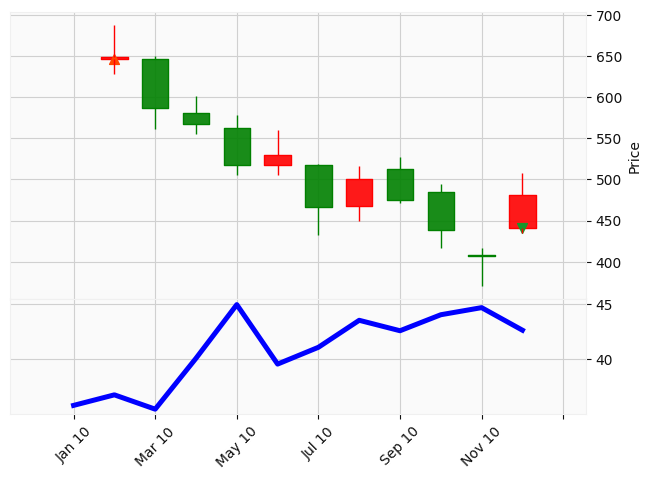

In [1]:
# 載入必要套件
from BackTest import ChartTrade, Performance
import pandas as pd
import mplfinance as mpf
import os
import yfinance as yf

datapath = './'

'''自訂函數'''


# 取得 公開資訊 月營收
def getTSEMonthRevenue(prod, st, en):
    # 檔案路徑與名稱
    bakfile = f"{datapath}/{prod}_{st}_{en}_TSE_MonthRevenue.csv"
    # 假如檔案不存在
    if not os.path.exists(bakfile):
        # 讀取月營收資料檔案
        tmpdata = pd.read_csv("月營收爬蟲資料.csv", encoding="utf-8")
        # 修改日期格式
        tmpdata["日期"] = pd.to_datetime(tmpdata["日期"].astype(str), format="%Y%m%d")
        # 使用正確的日期比較
        tmpdata = tmpdata.query("`公司代號` == @prod and @st <= `日期` <= @en").copy()
        # 使用 `日期` 欄位作為索引，並修改原始數據
        tmpdata.set_index("日期", inplace=True)
        # 將處理後的資料儲存為備份文件
        tmpdata.to_csv(bakfile)
    # 如果檔案存在，則直接讀取
    tmpdata = pd.read_csv(bakfile, index_col="日期", parse_dates=True)
    return tmpdata


# (2)取得資料：本地或是 Yahoo
def getDataFM(prod, st, en):
    # 檔案路徑
    bakfile = f"data/YF_{prod}_{st}_{en}_stock_daily_adj.csv"
    # 假如已經有 Excel 資料檔案
    if os.path.exists(bakfile):
        # 讀取 Excel 資料檔案
        data = pd.read_csv(bakfile, index_col="Date", parse_dates=True)
    # 假如 Excel 資料檔案不存在
    else:
        # 透過 yf 下載
        data = yf.download(f"{prod}.TW", start=st, end=en)
        # 下載的資料是英文的，處理欄位名稱，轉換為小寫
        # 轉換部分不包含索引，所以日期還是大寫開頭的 Date
        data.columns = [i.lower() for i in data.columns]
        # 假如下載後沒有資料
        if data.empty:
            print("無法從 Yahoo Finance 下載資料")
            # 傳回一個空的 pd
            return pd.DataFrame()
        # 假如資料 data 不是空的，依照指定路徑存擋
        data.to_csv(bakfile)
    # 存檔後，傳回資料
    return data


# 合併營收與股價資訊
def getTSEPriceAndRevenue(prod, st, en):
    '''
    這裡應該要修改每個函數來統一日期格式，之後再處理
    '''
    # 取得股價
    data1 = getDataFM(prod, st, en)
    # 取得營收
    st = st.replace("-", "")
    en = en.replace("-", "")
    data2 = getTSEMonthRevenue(prod, st, en)

    # 遍歷營收數據，將股價資訊添加在營收資料內
    # 特別注意，pandas 中進行邏輯運算要使用 `&` 運算子
    for i in range(1, data2.shape[0]):
        # 處理後的 tmpdata 包含了 data2 當前月份的所有股價信息
        # 可用於計算這個月的最高價、最低價、開盤價、收盤價和成交量
        tmpdata = data1.loc[
            # 選擇 data1 中日期大於 data2 目前索引的上一個月末的記錄
            (data1.index > data2.index[i - 1]) &
            # 選擇 data1 中日期小於或等於 data2 目前索引的月末的記錄
            (data1.index <= data2.index[i]),
        ]
        # 如果沒有資料：.shape[0] 可檢查是否不包含任何資料
        if tmpdata.shape[0] == 0:
            # 沒資料就跳過這一輪，不用刪除無妨
            continue
        '''假如有資料'''
        # 以第一天開盤為開盤
        data2.loc[data2.index[i], "open"] = tmpdata.loc[tmpdata.index[0], "open"]
        # 取出最大值為高點
        data2.loc[data2.index[i], "high"] = tmpdata.loc[:, "high"].max()
        # 取出最小時為低點
        data2.loc[data2.index[i], "low"] = tmpdata.loc[:, "low"].min()
        # 取出最後一天收盤為收盤
        data2.loc[data2.index[i], "close"] = tmpdata.loc[tmpdata.index[-1], "close"]
        # 取出所有成交量總和為成交量
        data2.loc[data2.index[i], "volume"] = tmpdata.loc[:, "volume"].sum()
    # 刪除重複的 row
    data2 = data2.drop_duplicates()
    return data2


if __name__ == '__main__':

    # 取得回測資料
    # 證券程式碼
    prod = "2330"
    # 起迄日期
    _start_date = "2022-01-01"
    _end_date = "2022-12-31"
    # 調用函數取得營收與股價合併的資訊
    data = getTSEPriceAndRevenue(prod, _start_date, _end_date)

    # 初始部位
    position = 0
    trade = pd.DataFrame()
    # 開始回測
    for i in range(data.shape[0] - 1):
        # 取得策略會應用到的變數
        c_time = data.index[i]
        c_high = data.loc[c_time, "high"]
        c_close = data.loc[c_time, "close"]
        c_earn = data.loc[c_time, "前期比較增減(%)"]
        # 取下一期資料做為進場資料
        n_time = data.index[i + 1]
        n_open = data.loc[n_time, "open"]

        # 進場程序
        if position == 0:
            if c_earn > 30:
                position = 1
                order_i = i
                order_time = n_time
                order_price = n_open
                order_unit = 1
        # 出場程序
        elif position == 1:
            # 出場邏輯
            if c_earn < 30 or i == data.shape[0] - 2:
                position = 0
                cover_time = n_time
                cover_price = n_open
                # 交易紀錄
                trade = trade._append(
                    pd.Series(
                        [
                            prod,
                            "Buy",
                            order_time,
                            order_price,
                            cover_time,
                            cover_price,
                            order_unit,
                        ]
                    ),
                    ignore_index=True,
                )

    # 繪製副圖
    addp = []
    # 月營收副圖
    addp.append(
        mpf.make_addplot(data["前期比較增減(%)"], panel=1, color="blue", secondary_y=False)
    )

    # 績效分析
    Performance(trade, "Stock")
    # 繪製K線圖與交易明細
    ChartTrade(data, trade, addp=addp, v_enable=False)
